In [3]:
import os
import math
import pickle
import xarray as xr
import datetime
from tqdm import tqdm
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cartopy 
import cartopy.feature as cfeature
import cartopy.crs as ccrs


In [4]:
# Get extreme PR days with minimum days appart
def ExtremeDays(Record, ExtremeNr, DistanceDD):
    SortedDates=np.argsort(Record)[::-1]
    rgiExtremePR=np.zeros((ExtremeNr))
    rgiExtremePR[:]=np.nan
    
    ii=1
    jj=1
    rgiExtremePR[0]=SortedDates[0]
    while ii < ExtremeNr:
        if np.nanmin(np.abs(rgiExtremePR - SortedDates[jj])) < DistanceDD:
            jj=jj+1
        else:
            rgiExtremePR[ii]=SortedDates[jj]
            jj=jj+1
            ii=ii+1
            
    return rgiExtremePR.astype('int')

In [5]:
# Distance calculation, degree to km (Haversine method) from Andy
def harvesine(lon1, lat1, lon2, lat2):
    rad = math.pi / 180  # degree to radian
    R = 6378.1  # earth average radius at equador (km)
    dlon = (lon2 - lon1) * rad
    dlat = (lat2 - lat1) * rad

    a = (np.sin(dlat / 2)) ** 2 + np.cos(lat1 * rad) * \
        np.cos(lat2 * rad) * (np.sin(dlon / 2)) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = R * c
    return(d)

In [6]:
def create_df_region(if_plot):
    '''
    Create a dictionary with names and ages
    and plot (for verification)
    '''
    data = {
        "region": ["BI", "IP", "FR", "ME", "SC", "AL", "MD", "EA"],
        "West":   [-10,   -10,  -5,   2,    5,    5,    3,    16],
        "East":   [2,     3,     5,   16,   30,   15,   25,   30],
        "South":  [50,    36,   44,   48,   55,   44,   36,   44],
        "North":  [59,    44,   50,   55,   70,   48,   44,   55]
    }

    # Create a DataFrame
    df_region = pd.DataFrame(data)

    # Set the index to 'name'
    df_region.set_index('region', inplace=True)

    if if_plot == 'plotting':
        # Plotting
        fig = plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))
 
        for nr in range(len(df_region)):
            left   = df_region.West.iloc[nr]
            right  = df_region.East.iloc[nr]
            bottom = df_region.South.iloc[nr]
            top    = df_region.North.iloc[nr]
            width_region  = df_region.East.iloc[nr] - df_region.West.iloc[nr]
            height_region = df_region.North.iloc[nr] - df_region.South.iloc[nr]
    
    
            # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
            ax.set_extent([-10, 30, 35, 70], crs=ccrs.PlateCarree())
            ax.coastlines( )
            ax.add_feature(cfeature.OCEAN, zorder=10, color='lightblue', alpha=0.04)
            ax.gridlines()
    
            # rectangle patch
            ax.add_patch(mpatches.Rectangle(xy=[left, bottom], width=width_region, height=height_region,
                                facecolor='None', edgecolor='r',
                                transform=ccrs.PlateCarree()))
            # Add text to the rectangle
            ax.text(0.5*(left+right), 0.5*(bottom+top), str(nr+1), transform=ccrs.PlateCarree(), fontsize=12, color='red')

    return df_region

In [7]:
#### Extreme_PR_events.ipynb
# find maximim daily precipitation of each region
def rw_prec_max(year_s, year_e, dir_obj, dataset, flnm_o):
    '''
    calculate daily maximum precipitation of 8 EU regions 
     
    '''
    
    df_region = create_df_region('plotting')
    print(df_region)
    n_region = len(df_region)

    is_first = True
    for year in range(year_s, year_e + 1):
        if res_EUR == 'CERRA':
            flnm = dir_obj + str(year) + '01_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc'
        else:
            flnm = dir_obj + str(year) + '01_'+ dataset +'_ObjectMasks__dt-3h_MOAAP-masks.nc'
            
        print(flnm)
        with xr.open_dataset(flnm) as ds:
            if is_first == True:
                Lat = ds.lat.values
                Lon = ds.lon.values
                n_lat = Lat.shape[0]
                n_lon = Lat.shape[1]
                is_first = False
                
            pr = ds.PR
            time_pr = pd.to_datetime(pr.time)
            
            # For 3-hourly data 
            yyyymmdd = (time_pr.year*10000 + time_pr.month*100 + time_pr.day).values[::8]
            n_day = len(yyyymmdd)
            
            PR_daily = np.zeros((n_day, n_lat, n_lon))
            for nd in range(n_day):
                PR_daily[nd,:,:] = pr[nd*8:nd*8+8, :,:].sum(dim='time')             
                 
        if year == year_s:
            PR_all = PR_daily
            Time = yyyymmdd      
        else:
            PR_all = np.concatenate((PR_all, PR_daily), axis=0)
            Time   = np.append(Time, yyyymmdd)

         
    PR_DailyMaxima_Reg = np.zeros((len(Time), n_region))
    for nr in range(n_region):
        left   = df_region.West.iloc[nr]
        right  = df_region.East.iloc[nr]
        bottom = df_region.South.iloc[nr]
        top    = df_region.North.iloc[nr]
        
        iNorth = np.argmin(np.abs(Lat[:,0] - top)) + 1
        iSouth = np.argmin(np.abs(Lat[:,0] - bottom)) 
        iEeast = np.argmin(np.abs(Lon[0,:] - right)) + 1
        iWest  = np.argmin(np.abs(Lon[0,:] - left)) 
        #print(df_region.index[nr], Lon[iSouth:iNorth,iWest:iEeast].min(),  Lon[iSouth:iNorth,iWest:iEeast].max())
        #print(df_region.index[nr], Lat[iSouth:iNorth,iWest:iEeast].min(),  Lat[iSouth:iNorth,iWest:iEeast].max())

        PR_re = PR_all[:, iSouth:iNorth, iWest:iEeast]
        #print(PR_re.shape)
        #print(np.nanmax(PR_re, axis=(1,2)).shape)
        PR_DailyMaxima_Reg[:,nr] = np.nanmax(PR_re, axis=(1,2))
        
    df = pd.DataFrame(PR_DailyMaxima_Reg, index=Time, columns=df_region.index)
    df.index.name = 'Time'

    df.to_csv(flnm_o, float_format='%.2f')  # Set index=False to omit row indices 


#### 8 regions setup

In [8]:
# Target grid resolusion
res_TarGrid = '44'
dir_d = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.'+res_TarGrid+'/'

dir_cerra = dir_d + 'CERRA/'
 
# OLD dir_o = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/'
dir_o = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/PAPER/'

# for CERRA
year_s = 1990
year_e = 2010
n_year = year_e - year_s + 1

flnm = dir_cerra + '201001_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc'

ncid = Dataset(flnm)
Lat = np.squeeze(ncid.variables['lat'][:])
Lon = np.squeeze(ncid.variables['lon'][:])
nx = Lon.shape[0]
ny = Lon.shape[1]
ncid.close()
print('Lat Lon grid is from ', flnm, nx, ny)

lat_1d = Lat[:,0]
lon_1d = Lon[0]
#lon_grid, lat_grid = np.meshgrid(lon_1d,lat_1d)

n_lon = len(lon_1d)
n_lat = len(lat_1d)

Lat Lon grid is from  /glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/201001_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc 92 187


#### calculate daily maximum precipitation of each region

Output file: /glade/campaign/mmm/c3we/mingge/FRONTIERS/PAPER/daily-max-PR_CERRA_CERRA.cvs 0
working on BI
working on IP
working on FR
working on ME
working on SC
working on AL
working on MD
working on EA
Output file: /glade/campaign/mmm/c3we/mingge/FRONTIERS/PAPER/daily-max-PR_CLMcom-CCLM5-0-6_v1_EUR-44.cvs 0
working on BI
working on IP
working on FR
working on ME
working on SC
working on AL
working on MD
working on EA
Output file: /glade/campaign/mmm/c3we/mingge/FRONTIERS/PAPER/daily-max-PR_MOHC-HadGEM3-RA_v1_EUR-44.cvs 1
working on BI
working on IP
working on FR
working on ME
working on SC
working on AL
working on MD
working on EA
Output file: /glade/campaign/mmm/c3we/mingge/FRONTIERS/PAPER/daily-max-PR_UCAN-WRF331G_v01_EUR-44.cvs 2
working on BI
working on IP
working on FR
working on ME
working on SC
working on AL
working on MD
working on EA
Output file: /glade/campaign/mmm/c3we/mingge/FRONTIERS/PAPER/daily-max-PR_CLMcom-ETH-COSMO-crCLIM-v1-1_v1_EUR-11.cvs 0
working on BI
working on

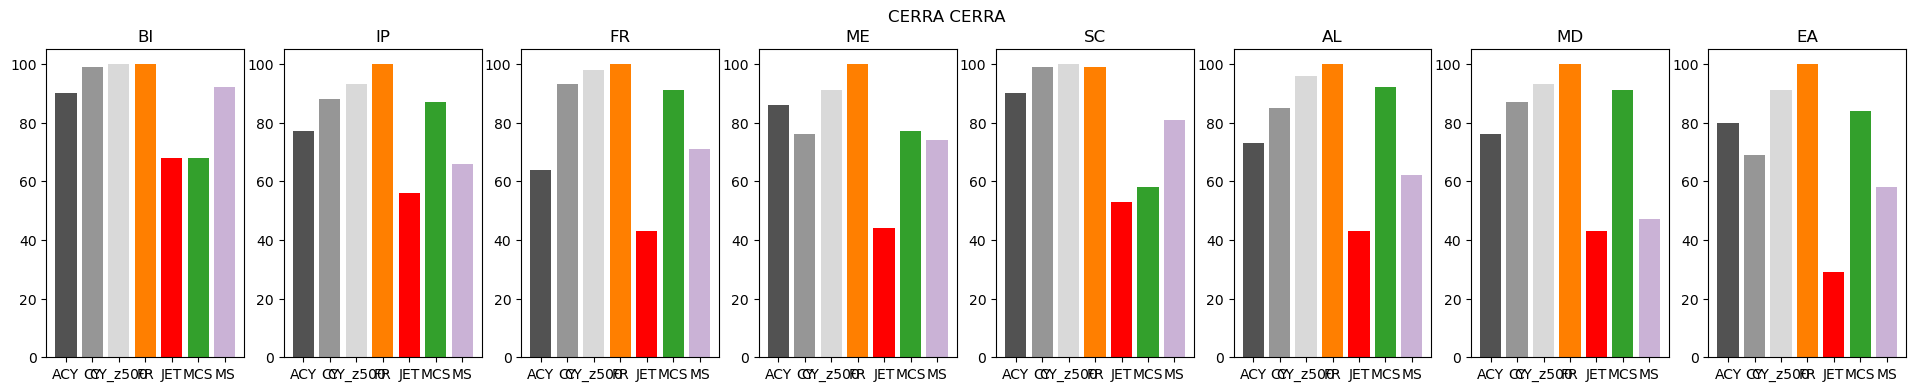

In [ ]:
%%time
EUR_1d = ['CERRA', 'EUR-44', 'EUR-11']
#EUR_1d = ['CERRA']
Nr_extremes = 100

# Each event has to be at least 3 days apart to reduce the effect of dependent events 
LagDD = 3

# Categories = ['CY', 'TC', 'AR', 'IVT', 'MCS', 'FR', 'AC', 'BT', 'PR']
Categories = [ 'BT', 'ACY', 'CY', 'CY_z500', 'FR', 'JET', 'MCS', 'MS' ]  
COLORS=['#000000', '#525252', '#969696','#d9d9d9', 
        '#ff7f00','r', '#33a02c', '#cab2d6', '#6a3d9a',
       '#8c510a', '#bf812d', '#dfc27d','#abd9e9', '#4575b4']

n_region = 8


Search_Radius = 1000. # in km
for res_EUR in EUR_1d:
    
    if res_EUR == 'EUR-44':
        model_s = ['CLMcom-CCLM5-0-6_v1', 
                   'MOHC-HadGEM3-RA_v1', 
                   'UCAN-WRF331G_v01']
    elif res_EUR == 'EUR-11':
        model_s = ['CLMcom-ETH-COSMO-crCLIM-v1-1_v1', \
                'MOHC-HadREM3-GA7-05_v1',\
                'ICTP-RegCM4-6_v1']
    elif res_EUR == 'CERRA':
        model_s = ['CERRA']

    n_model = len(model_s)
     
    for nm in range(n_model):
        if res_EUR == 'CERRA':
            dir_obj = dir_d + res_EUR + '/'
            flnm_o = dir_o + 'daily-max-PR_' + 'CERRA_' + res_EUR + '.cvs'
        else:
            dir_obj = dir_d + res_EUR + '/' + model_s[nm] + '/'
            flnm_o = dir_o + 'daily-max-PR_' + model_s[nm] + '_' + res_EUR + '.cvs'

        print('Output file:', flnm_o, nm)
        if os.path.isfile(flnm_o) != True:
            rw_prec_max(year_s, year_e, dir_obj, model_s[nm], flnm_o)

         
        df = pd.read_csv(flnm_o)
        n_region = len(df.columns) - 1
        rfiExtremeDays = np.zeros((Nr_extremes, n_region))#, dtype=int)
        rfiExtremeDays[:] = np.nan

        #  convert numpy array from numpy.int64 to datetime?
        TimeDD = pd.to_datetime(df.Time.values.astype(str), format='%Y%m%d') 
        ExtrPR_Features = np.zeros((n_region, Nr_extremes,len(Categories)))
        ChordMatrix = np.zeros((n_region, len(Categories),len(Categories)))
        
        for re in range(n_region):
            # the first column is 'Time'
            data_1d = df[df.columns[re+1]].values
            rfiExtremeDays[:,re] = ExtremeDays(data_1d, Nr_extremes, LagDD) 
            
            print('working on ' + df.columns[re+1])
            SaveFile = dir_o + df.columns[re+1]+"_"+str(Nr_extremes)+"-Extr_"+str(Search_Radius)+"km-radius_"+ model_s[nm] + '_' + res_EUR +".pkl"
            if os.path.isfile(SaveFile) == False:
                dfExtrReg = {}
                #for ex in tqdm(range(Nr_extremes)):
                for ex in (range(Nr_extremes)):
                    dfEVENT = {}
                    DDact = int(rfiExtremeDays[ex,re])
                    ExtremeDay = TimeDD[DDact]
                    pr = df[df.columns[re+1]] #.values
                    PRact = pr[DDact]
                    print(ExtremeDay, PRact)
         
                    # Read features
                    YYYY = str(ExtremeDay.year)
        
                    if res_EUR == 'CERRA':
                        flnm = dir_obj + str(YYYY) + '01_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc'
                    else:
                        flnm = dir_obj + str(YYYY) + '01_'+ model_s[nm] +'_ObjectMasks__dt-3h_MOAAP-masks.nc'
        
                    StartDay = datetime.datetime(int(YYYY), 1, 1, 0)
                    StopDay = datetime.datetime(int(YYYY), 12, 31, 23)
                    DATE = pd.date_range(StartDay, end=StopDay, freq='3h')
                    # array -> int 
                    rgiDD = np.where(DATE==ExtremeDay)[0][0]
                   
                    print('    Reading: '+flnm)
                    ncid=Dataset(flnm, mode='r')
                    PR_daily= np.sum(np.squeeze(ncid.variables['PR'][rgiDD:rgiDD+8,:,:]), axis = 0)
        
                    # Location of max. precipitation defines search area
                    rgiMax = np.where(abs(PRact- PR_daily)<0.01) 
                    LatMax = Lat[rgiMax[0][0],rgiMax[1][0]]
                    print(PR_daily[rgiMax[0][0],rgiMax[1][0]], 'vs', PRact)
         
                    LatCent = Lat[rgiMax[0][0],rgiMax[1][0]]
                    LonCent = Lon[rgiMax[0][0],rgiMax[1][0]]
                    DIST = harvesine(Lon, Lat, LonCent, LatCent)
                    SEARCH_rad = DIST < Search_Radius

                    BT_obj  = np.squeeze(ncid.variables['BT_Objects'][rgiDD:rgiDD+8,:,:])
                    ACY_obj = np.squeeze(ncid.variables['ACY_Objects'][rgiDD:rgiDD+8,:,:])
                    CY_obj  = np.squeeze(ncid.variables['CY_Objects'][rgiDD:rgiDD+8,:,:])
                    CY_z500_obj = np.squeeze(ncid.variables['CY_z500_Objects'][rgiDD:rgiDD+8,:,:])
                    FR_obj  = np.squeeze(ncid.variables['FR_Objects'][rgiDD:rgiDD+8,:,:])
                    JET_obj = np.squeeze(ncid.variables['JET_Objects'][rgiDD:rgiDD+8,:,:])
                    MCS_obj = np.squeeze(ncid.variables['MCS_Tb_Objects'][rgiDD:rgiDD+8,:,:])
                    MS_obj  = np.squeeze(ncid.variables['MS_Objects'][rgiDD:rgiDD+8,:,:])
                    PR_obj  = np.squeeze(ncid.variables['PR_Objects'][rgiDD:rgiDD+8,:,:])
        
                    ncid.close()

                    # Search for features in the search radius
                    dfEVENT['BT'] = list(np.delete(np.unique(BT_obj[:, SEARCH_rad]), 0).astype(int))
                    dfEVENT['ACY'] = list(np.delete(np.unique(ACY_obj[:, SEARCH_rad]), 0).astype(int))
                    dfEVENT['CY'] = list(np.delete(np.unique(CY_obj[:, SEARCH_rad]), 0).astype(int))
                    dfEVENT['CY_z500'] = list(np.delete(np.unique(CY_z500_obj[:, SEARCH_rad]), 0).astype(int))
                    dfEVENT['FR'] = list(np.delete(np.unique(FR_obj[:, SEARCH_rad]), 0).astype(int))
                    dfEVENT['JET'] = list(np.delete(np.unique(JET_obj[:, SEARCH_rad]), 0).astype(int))
                    dfEVENT['MCS'] = list(np.delete(np.unique(MCS_obj[:, SEARCH_rad]), 0).astype(int))
                    dfEVENT['MS'] = list(np.delete(np.unique(MS_obj[:, SEARCH_rad]), 0).astype(int))
                    dfEVENT['PR'] = list(np.delete(np.unique(PR_obj[:, SEARCH_rad]), 0).astype(int)) 
                    dfEVENT['Time'] = DATE[rgiDD]
                    dfEVENT['PeakPR'] = np.nanmax(PR_daily)
                    dfEVENT['LatCent'] = np.nanmax(LatCent)
                    dfEVENT['LonCent'] = np.nanmax(LonCent)
                    # 10 characters of ExtremeDay:yyyy-mm-dd
                    dfExtrReg[str(ExtremeDay)[:10]] = dfEVENT
                ff = open(SaveFile,"wb")
                pickle.dump(dfExtrReg,ff)
                ff.close()
                #grEXTR[df.columns[re+1]] = dfExtrReg
             
            file = open(SaveFile,'rb')
            dfEVENT = pickle.load(file)
        
            if len(dfEVENT.keys()) < 100:
                print(SaveFile)
                # remove files that do not have 100 events
                # subprocess.Popen("rm "+SaveFile, shell=True) #, stdout=subprocess.PIPE).stdout.read()
                
            for ev in range(len(dfEVENT.keys())):
                DATA = dfEVENT[list(dfEVENT.keys())[ev]]
                for ca in range(len(Categories)):
                    if len(DATA[Categories[ca]]) > 0:
                        ExtrPR_Features[re,ev,ca] = 1
                # Data for chord graph
                PROCESSES = np.zeros(len(Categories))
                for ca in range(len(Categories)):
                    if len(DATA[Categories[ca]]) > 0:
                        PROCESSES[ca] = 1
                for ca1 in range(len(Categories)):
                    if (np.sum(PROCESSES) == 1) & (PROCESSES[ca1] == 1):
                        ChordMatrix[re,ca1,ca1] = ChordMatrix[re,ca1,ca1] + 1
                    else:
                        for ca2 in range(len(Categories)):
                            if (ca1 != ca2) & (PROCESSES[ca2] == 1) & (PROCESSES[ca1] == 1):
                                ChordMatrix[re,ca1,ca2] = ChordMatrix[re,ca1,ca2] + 1
   
        fig, ax = plt.subplots(1, 8, figsize=(24, 4))
        for re in range(n_region):
            ax[re].bar(Categories[1:], np.nansum(ExtrPR_Features[re,:,1:], axis=0), color=COLORS[1:])
            ax[re].set_title(df.columns[re+1])    
        fig.suptitle(model_s[nm] + " " + res_EUR)

